In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import lognorm

# Estimating density from samples

Often, we will be interested in the probability density (concentration, distribution) of samples, rather than the individual samples themselves. Estimating a distribution from discrete samples is a common thing to do in applied statistics generally, and several approaches exist. Search for "density estimation" to read more.

The general idea is that we have samples from an unknown distribution (in our case that could for example be a set of positions from solving an SDE), and we want to find a good representation of the unknown distribution. We will consider two fairly straightforward methods:
* Histograms
* Kernel Density Estimation (KDE)

## Histograms

We have already used histograms many times, but we haven't really discussed the details.

Advantages of histograms:
* Easy to understand
* Simple to implement, library functions widely available
* Works well if we have many samples (samples are densely spaced relative to the resolution we want)

Disadvantages of histograms:
* Does not give a continuous, smooth function (though we can interpolate to get one)
* Have to choose bin size somehow
* Poor results when there are few particles per bin

Below, we see some examples. To simplify the example, we just draw random samples from some distribution, rather than solving an SDE, but the idea is the same now matter how the samples are obtained.

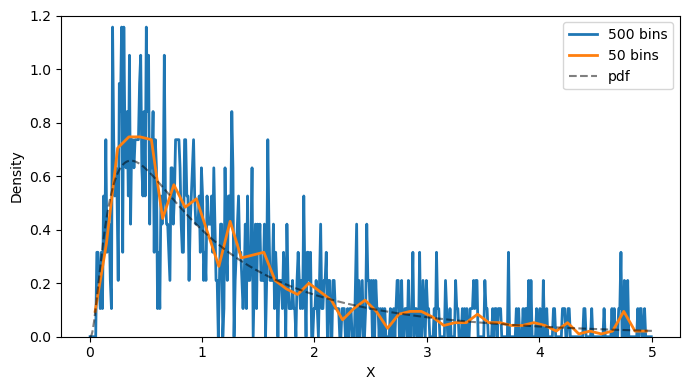

In [44]:
# Draw some samples from a distribution
Np = 1000
X0 = lognorm.rvs(1, size=Np)

fig = plt.figure(figsize=(7,4))

for Nbins in [500, 50]:
    # Histogram bins
    bins, dx =np.linspace(0, 5, Nbins+1, retstep=True) # bins
    mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins
    h, _ = np.histogram(X0, bins, density=True)
    plt.plot(mids, h, lw=2, label=f'{Nbins} bins')
    
# Plot analytical pdf
x = np.linspace(0, 5, 1000)
plt.plot(x, lognorm.pdf(x, s=1), '--', c='k', alpha=0.5, label='pdf')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.ylim(0, 1.2)
plt.tight_layout()

## Kernel density estimation (KDE)

In KDE (see, e.g., Silverman 1986), each sample $i$ is represented by a "kernel" $\kappa_i(x)$. The kernel is essentially a positive function that integrates to 1, and which is symmetric about a maximum at the sample position, $x_i$, and 0 far away from the sample. The probability density from $N_p$ samples is then given by the sum of all the kernels:

$$ p(x) = \frac{1}{N_p} \sum_{i=1}^{N_p} \kappa_i(x). $$

An example of a kernel function could be a Gaussian with mean at the sample position, $\mu=x_i$, leaving the standard deviation of the Gaussian as a free parameter. In the context of KDE, the parameter that determines the width of the kernel is usually called the bandwidth. An example is shown below, using a Gausisan kernel and different bandwidths / standard deviations.

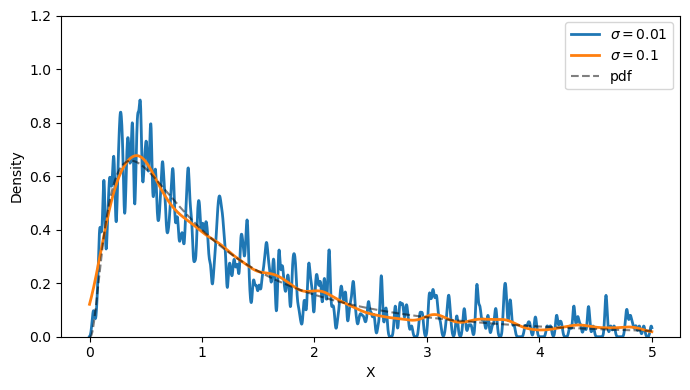

In [46]:
# Draw some samples from a distribution
Np = 1000
X0 = lognorm.rvs(1, size=Np)

fig = plt.figure(figsize=(7,4))

x = np.linspace(0, 5, 2000)

def gauss(x, mu, sigma):
    return np.exp(-0.5*(x-mu)**2/sigma**2) / (np.sqrt(2*np.pi)*sigma)

for sigma in [1e-2, 1e-1]:
    p = np.sum(gauss(x[:,None], X0[None,:], sigma), axis=1) / Np
    plt.plot(x, p, lw=2, label=f'$\sigma={sigma}$')
    
# Plot analytical pdf
x = np.linspace(0, 5, 1000)
plt.plot(x, lognorm.pdf(x, s=1), '--', c='k', alpha=0.5, label='pdf')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.ylim(0, 1.2)
plt.tight_layout()

As with histograms, there are also advantages and disadvantages of KDE:

Advantages of KDE:
* Gives density as a smooth, continuous function (if smooth kernel is chosen)
* Simple to implement, library functions widely available
* Can be less noisy than histogram

Disadvantages of KDE:
* Have to choose both kernel function and bandwidth (though bandwidth is usually most important)
* Need to think about reflection at boundaries

Below are shown a couple of additional KDE example, using the KDEpy library.

In [48]:
from KDEpy import FFTKDE

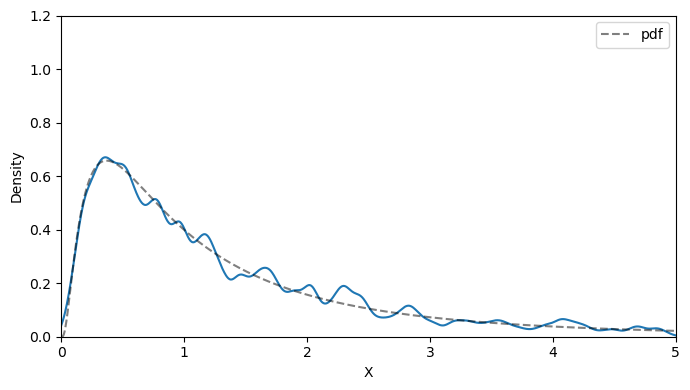

In [64]:
# Draw some samples from a distribution
Np = 1000
X0 = lognorm.rvs(1, size=Np)

fig = plt.figure(figsize=(7,4))

x = np.linspace(0, 50, 10000)

# Choose kernel and algorithm to find bandwidth
# (or specify bandwidth as a number)
estimator = FFTKDE(kernel='gaussian', bw='ISJ')
# Fit to data, and evaluate
p = estimator.fit(X0).evaluate(x)
# Plot estimate
plt.plot(x, p)

# Plot analytical pdf
plt.plot(x, lognorm.pdf(x, s=1), '--', c='k', alpha=0.5, label='pdf')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.ylim(0, 1.2)
plt.xlim(0, 5)
plt.tight_layout()

## Handling boundaries in KDE

If we have a distribution that is zero outside some boundary, for example due to solving an SDE with reflecting boundary, we may have to handle that specially in the KDE approach. Say we have a uniform distribution from 0 to 1.  Due to the finite bandwidth, any sample that is close to the boundary, compared to the bandwidth, will "lose" some of its probability to the region outside the boundary.

This is illustrated below.

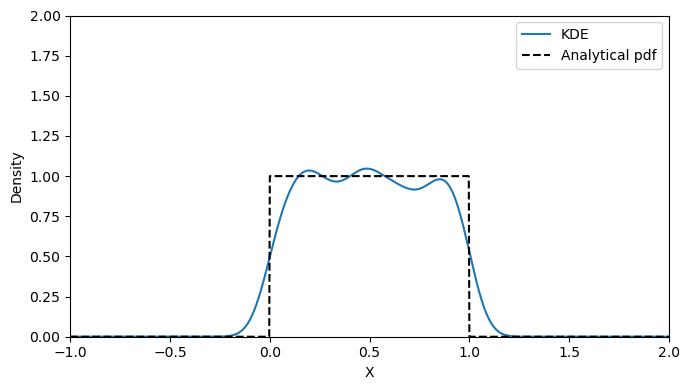

In [71]:
Np = 1000
X0 = np.random.uniform(low=0, high=1, size=Np)


fig = plt.figure(figsize=(7,4))

x = np.linspace(-1, 2, 1000)

# Choose kernel and algorithm to find bandwidth
# (or specify bandwidth as a number)
estimator = FFTKDE(kernel='gaussian', bw='silverman')
# Fit to data, and evaluate
p = estimator.fit(X0).evaluate(x)
# Plot estimate
plt.plot(x, p, label='KDE')

#Plot the actual density
plt.plot(x, np.where((0 <= x) & (x < 1), 1.0, 0.0), '--', c='k', label='Analytical pdf')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.xlim(-1, 2)
plt.tight_layout()

An approach to dealing with this problem is to first reflect the data prior to using KDE, and then setting the density to zero outside the boundaries. See also example at https://kdepy.readthedocs.io/en/latest/examples.html#boundary-correction-using-mirroring

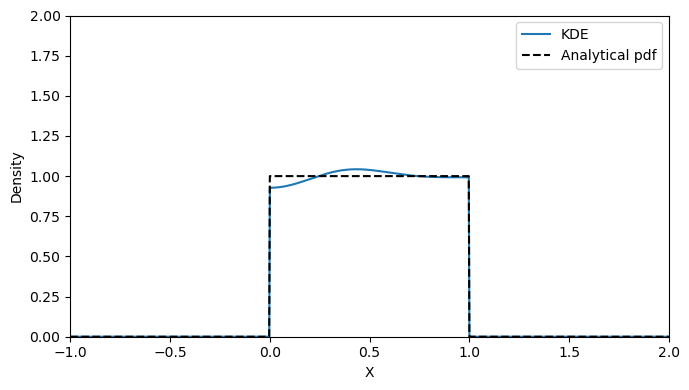

In [74]:
Np = 1000

# Draw random samples
X0 = np.random.uniform(low=0, high=1, size=Np)
# Mirror samples about both boundaries
X0 = np.concatenate([ X0, -X0, 2 - X0])


fig = plt.figure(figsize=(7,4))

x = np.linspace(-1, 2, 1000)

# Choose kernel and algorithm to find bandwidth
# (or specify bandwidth as a number)
estimator = FFTKDE(kernel='gaussian', bw='silverman')
# Fit to data, and evaluate
p = estimator.fit(X0).evaluate(x)
# Multiply by 3 and set to zero outside boundaries
p = 3*np.where((0 <= x) & (x < 1), p, 0)
# Plot estimate
plt.plot(x, p, label='KDE')

#Plot the actual density
plt.plot(x, np.where((0 <= x) & (x < 1), 1.0, 0.0), '--', c='k', label='Analytical pdf')

plt.legend()
plt.xlabel('X')
plt.ylabel('Density')
plt.ylim(0, 2)
plt.xlim(-1, 2)
plt.tight_layout()

# References

Silverman, B. W. (1986). _Density estimation for statistics and data analysis_. CRC press.